In [5]:
# Ensure notebook runs from project root
import os
os.chdir("..")  # Adjust depending on your folder structure

# Check current working directory
%pwd

# Imports
import sys
sys.path.append('src')  # Add src folder to path

from src.data.data_loader import DataLoader
from src.data.data_preprocessor import DataPreprocessor
from src.models.mmm_model import MarketingMixModel
from src.models.model_validation import ModelEvaluator
from src.visualization.plotting import MMMVisualizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error


In [6]:
# Correct path to config.yaml
config_path = os.path.join("config", "config.yaml")

# Initialize components
loader = DataLoader(config_path=config_path)
preprocessor = DataPreprocessor()
evaluator = ModelEvaluator()
visualizer = MMMVisualizer()

# Load raw data
df = loader.load_raw_data()

# Data Exploration
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample Data:")
display(df.head())

print("\nDescriptive Statistics:")
display(df.describe())

print("\nMissing Values:")
display(df.isnull().sum())


Dataset Shape: (104, 12)

Columns: ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue', 'date']

Sample Data:


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,date
0,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,2023-09-17
1,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,2023-09-24
2,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,2023-10-01
3,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,2023-10-08
4,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,2023-10-15



Descriptive Statistics:


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,date
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104
mean,5346.302500,1543.866442,955.632212,1019.342885,747.465000,72414.509615,99.962500,0.211538,120691.067308,23623.115385,49053.945096,2024-09-11 12:00:00
min,2456.940000,0.000000,0.000000,0.000000,0.000000,0.000000,87.560000,0.000000,68655.000000,10460.000000,1.000000,2023-09-17 00:00:00
25%,4538.977500,0.000000,0.000000,0.000000,0.000000,38318.250000,94.207500,0.000000,102971.500000,19252.500000,474.852500,2024-03-15 06:00:00
50%,5293.780000,0.000000,0.000000,0.000000,0.000000,81109.500000,99.490000,0.000000,120237.000000,22459.500000,972.065000,2024-09-11 12:00:00
75%,6033.325000,3374.205000,2487.172500,2395.350000,1705.872500,110281.250000,105.395000,0.000000,136594.000000,28107.000000,45773.732500,2025-03-10 18:00:00
max,9325.180000,6083.160000,4143.250000,3877.990000,3126.040000,143477.000000,113.380000,1.000000,185460.000000,40153.000000,398453.530000,2025-09-07 00:00:00
std,1168.961177,1863.350279,1376.993132,1349.184250,982.088273,47778.448985,6.496186,0.410377,25158.181476,6661.362493,93329.607019,NaN



Missing Values:


facebook_spend      0
google_spend        0
tiktok_spend        0
instagram_spend     0
snapchat_spend      0
social_followers    0
average_price       0
promotions          0
emails_send         0
sms_send            0
revenue             0
date                0
dtype: int64

In [8]:
# Preprocess data
processed_df = preprocessor.process_data(df, loader.config)

# Split data into training and test sets
train_df, test_df = train_test_split(
    processed_df,
    test_size=0.2,
    random_state=42
)


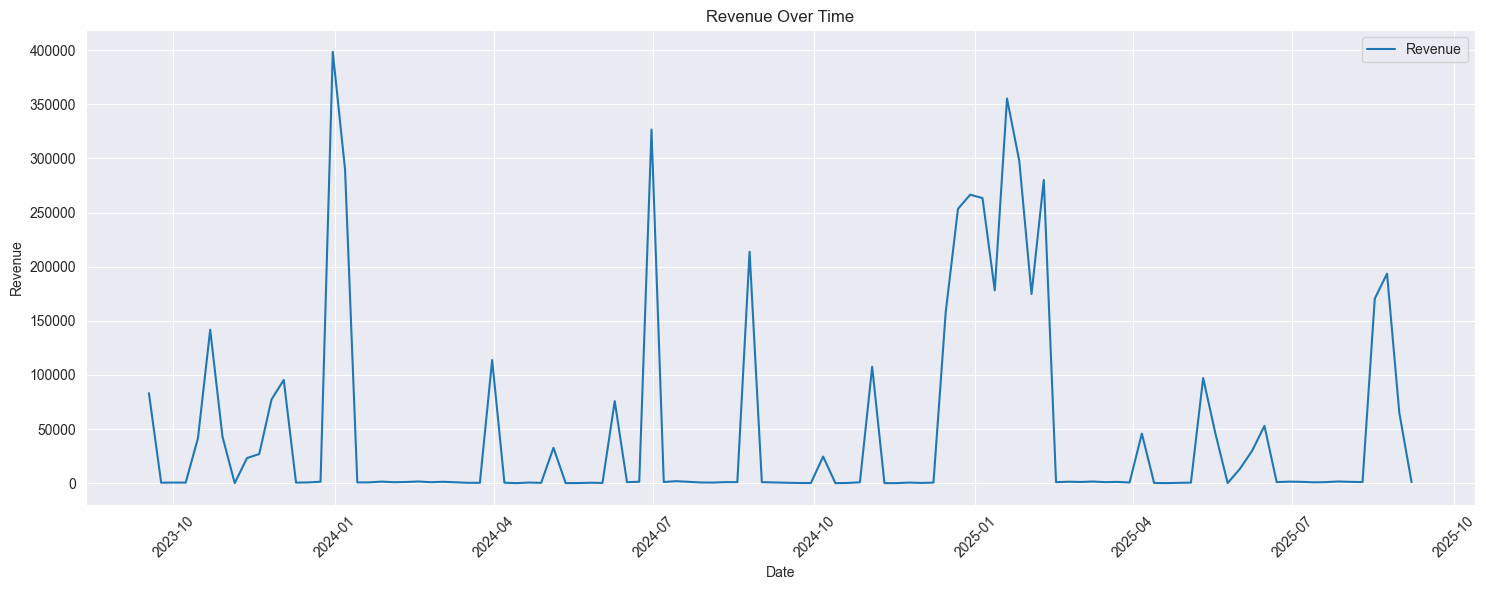

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['revenue'], label='Revenue')
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


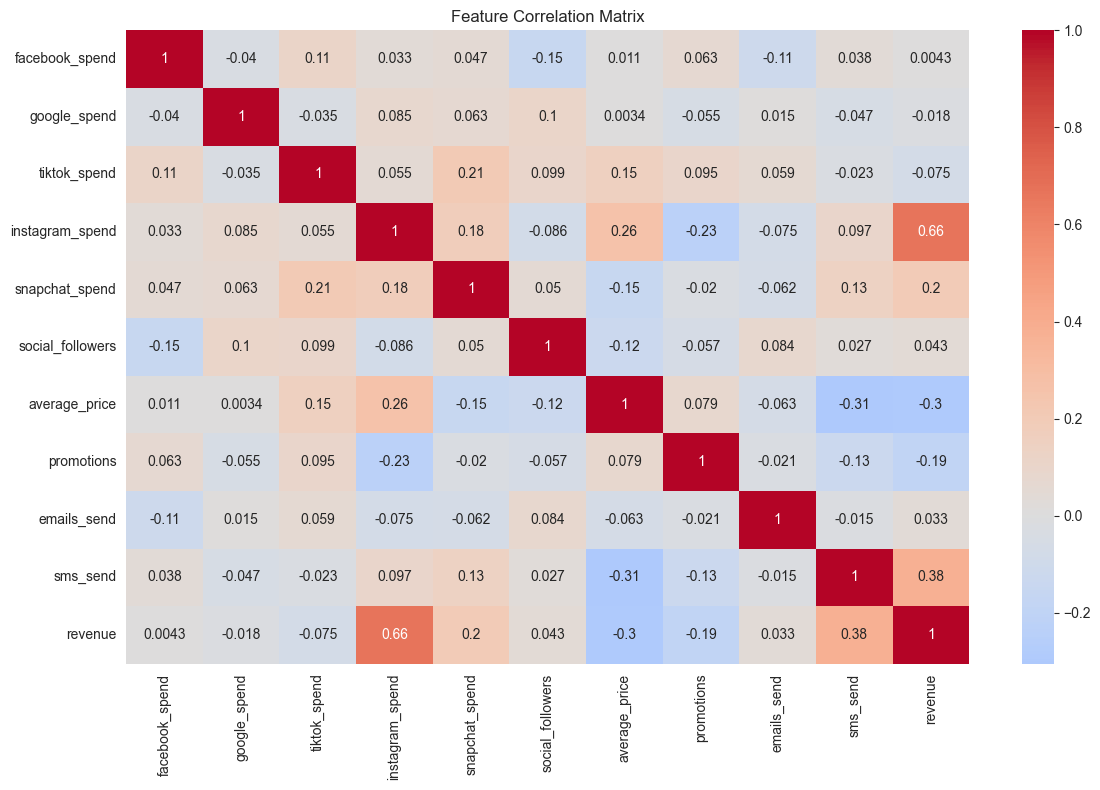

In [10]:
# Drop 'date' column for correlation
correlation_matrix = df.drop(columns=['date']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [11]:
# Initialize and train the model
model = MarketingMixModel(loader.config)
model.fit(train_df)

# Predictions on test set
mediator_pred, revenue_pred = model.predict(test_df)

# Model metrics using evaluator
metrics = evaluator.calculate_metrics(
    test_df[loader.config['features']['target']],
    revenue_pred
)

print('Model Performance:')
for metric, value in metrics.items():
    print(f'{metric}: {value:.4f}')


Model Performance:
rmse: 19723.5548
r2: 0.7569
mape: 6369.8026


In [12]:
# Predictions on training and test sets
train_mediator_pred, train_revenue_pred = model.predict(train_df)
test_mediator_pred, test_revenue_pred = model.predict(test_df)

# Function to print metrics
def print_metrics(y_true, y_pred, dataset_name):
    print(f"\n{dataset_name} Set Metrics:")
    print("-" * 20)
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred)*100:.2f}%")

# Print metrics for training set
print_metrics(
    train_df[loader.config['features']['target']], 
    train_revenue_pred,
    "Training"
)

# Print metrics for test set
print_metrics(
    test_df[loader.config['features']['target']], 
    test_revenue_pred,
    "Test"
)



Training Set Metrics:
--------------------
R² Score: 1.0000
MAPE: 0.04%

Test Set Metrics:
--------------------
R² Score: 0.7569
MAPE: 6369.80%


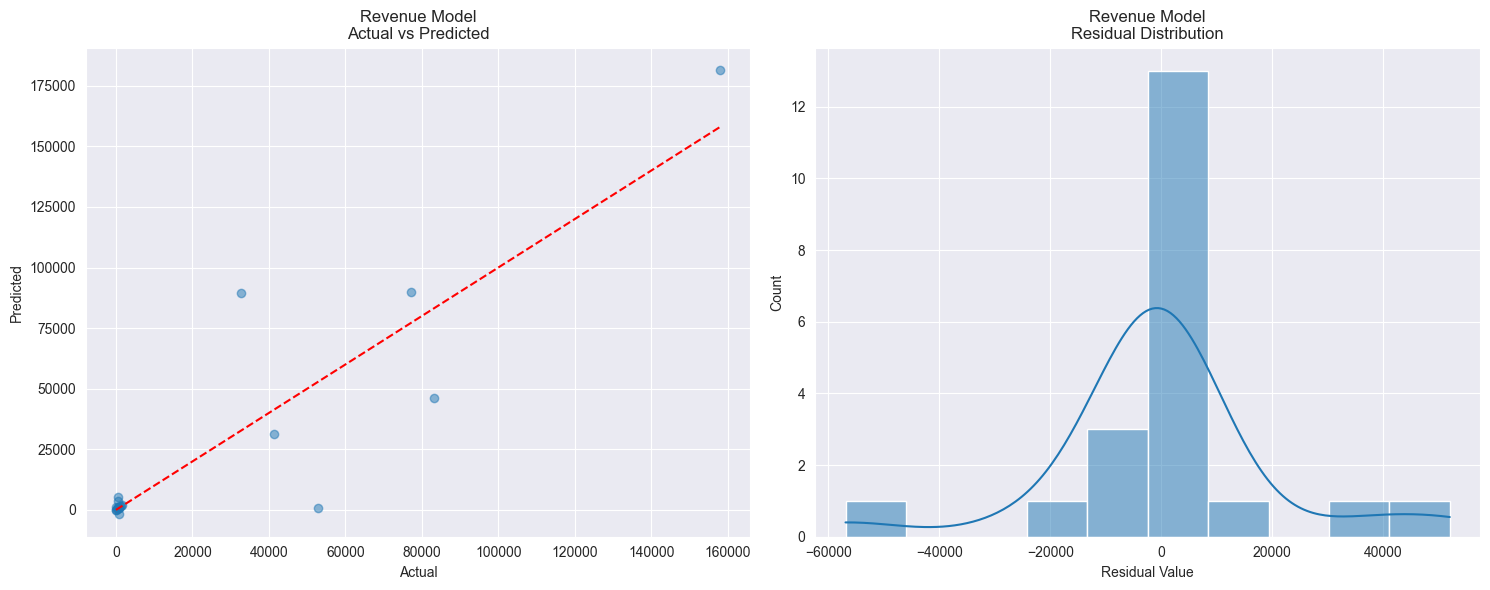

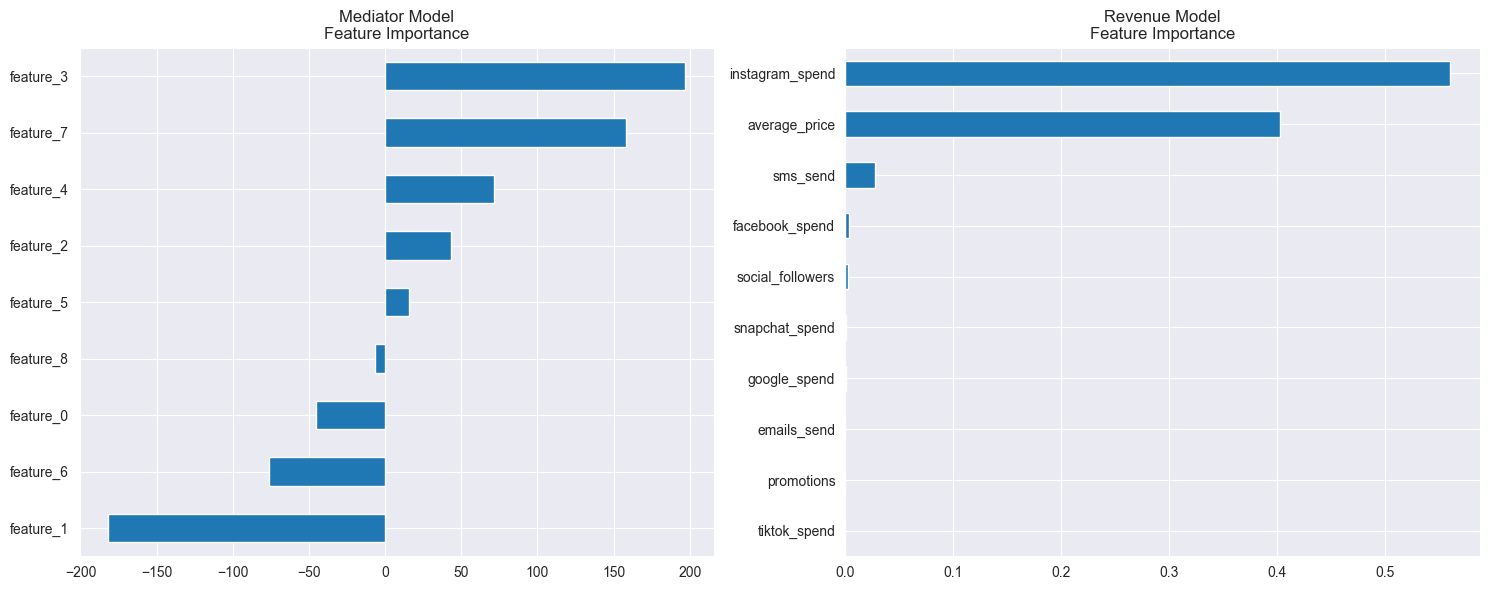

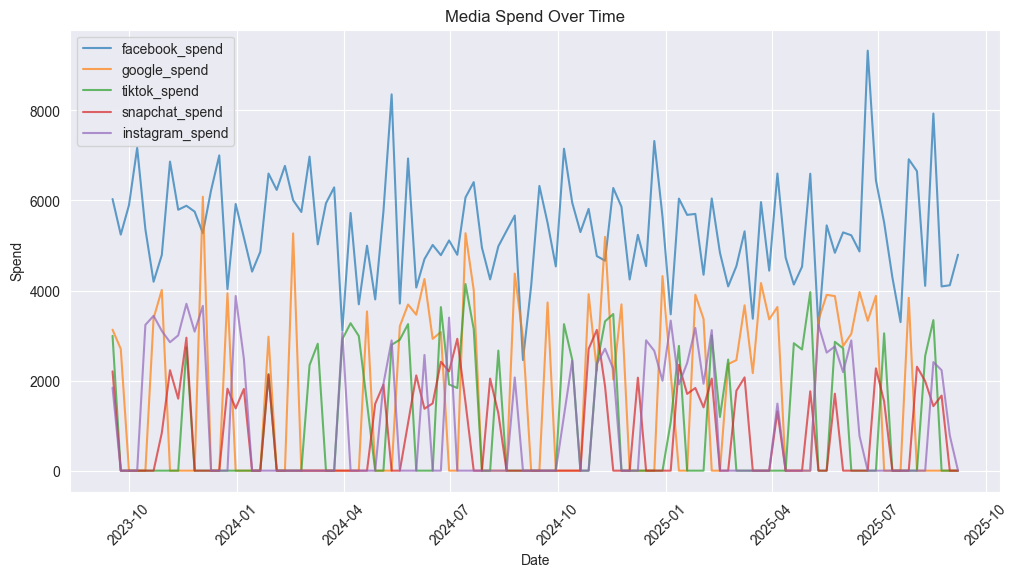

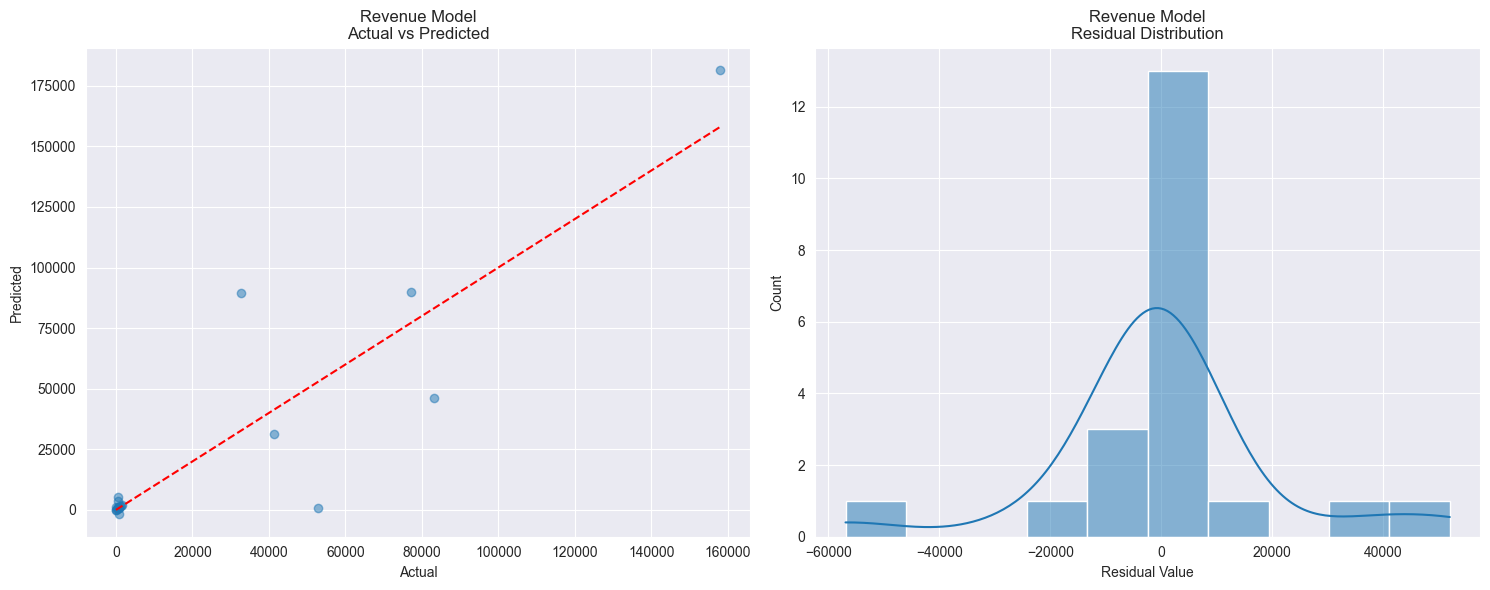

In [13]:
# Feature importance
visualizer.plot_feature_importance(model.get_feature_importance())

# Media spend over time
media_channels = loader.config['features']['media_channels']
visualizer.plot_spend_over_time(df, media_channels)

# Model diagnostics
visualizer.plot_model_diagnostics(
    test_df[loader.config['features']['target']],
    revenue_pred,
    'Revenue Model'
)
